# Hydropower energy generation in the Italian Alps

This Notebook contains a hands-on example of the Energy module of the $\color{red}{\text{SnowPower solution, part of the I-NERGY project}}$. A sample set of data is provided along with this Notebook. The region of interest for this case study are the Alpine watersheds located within the Northern Italy electricity bidding zone (in figure), that are:

In [2]:
import geopandas as gpd
from matplotlib import cm
import proplot as plot
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

basins = gpd.read_file(r'data/italy_basins.shp')

proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode
proj_create: init=epsg:/init=IGNF: syntax not supported in non-PROJ4 emulation mode


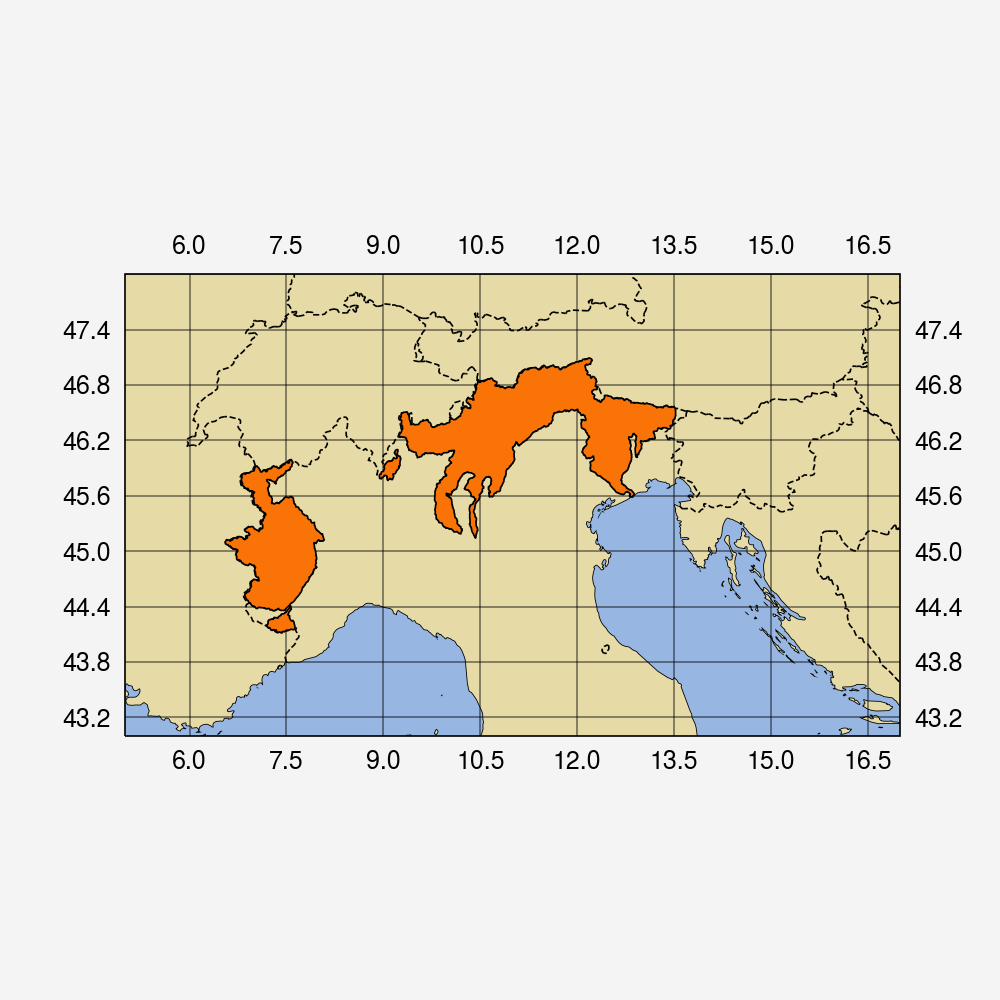

In [3]:
plt.figure(figsize=(5,5))
    
ax = plt.subplot(111, projection=ccrs.PlateCarree())

ax.set_extent([5,17,43,48])

resol = '10m'  # use data at this scale
bodr = cartopy.feature.NaturalEarthFeature(category='cultural', \
    name='admin_0_boundary_lines_land', scale=resol, facecolor='none', alpha=0.7)
land = cartopy.feature.NaturalEarthFeature('physical', 'land', \
    scale=resol, edgecolor='k', facecolor=cfeature.COLORS['land'])
ocean = cartopy.feature.NaturalEarthFeature('physical', 'ocean', \
    scale=resol, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='beige')
ax.add_feature(ocean, linewidth=0.2 )
ax.add_feature(bodr, linestyle='--', edgecolor='k', alpha=1)

basins.plot(ax=ax, zorder=10, color='orange',edgecolor='k')
l = ax.gridlines(alpha=.5, draw_labels=True)

The Energy module of SnowPower ingests information about water runoff in the basin, as well as other features describing meteorological conditions such as temperature, and energy market demand.

The data that will be used to estimate energy generation can be loaded as:

In [4]:
data = pd.read_csv(r'data/dataset_casestudy_IT.csv')
data['time'] = pd.to_datetime(data['time'])
data.head()

,time,t2m_mean,runoff,e_load,energy
0,2017-04-01,279.16672,6.288020e+06,15427.208333,0.192471
1,2017-04-02,278.62408,6.494626e+06,12936.833333,0.138531
2,2017-04-03,280.52826,4.787549e+06,17789.916667,0.385262
3,2017-04-04,279.40994,5.887215e+06,19698.041667,0.462773
4,2017-04-05,277.88956,4.846554e+06,19894.875000,0.347146


The dataset spans over the melting seasons (April-September) of 2017-2020. The variables included in the dataset are:
- **time**
- **t2m_mean** -- mean daily air temperature at 2m from ground surface, averaged over the Italian watersheds, from ERA5 data
- **runoff** -- water runoff in the study area in m$^{3}$/s, output of the Runoff model of SnowPower
- **e_load** -- daily energy load in the Northern Italy bidding zone from ENTSO-E data
- **energy** -- energy generation in GWh/km$^{2}$, processed from ENTSO-E data

The **energy** column will be used as target. 

Before proceeding to the training and testing of the energy model, we add a new feature, **day_of_year**: the **time** column is not suitable to be used as a feature, yet the information provided by the calendar day allows the model to learn seasonal behaviors.




In [5]:
data['day_of_year'] = data.time.dt.dayofyear
data.head()

,time,t2m_mean,runoff,e_load,energy,day_of_year
0,2017-04-01,279.16672,6.288020e+06,15427.208333,0.192471,91
1,2017-04-02,278.62408,6.494626e+06,12936.833333,0.138531,92
2,2017-04-03,280.52826,4.787549e+06,17789.916667,0.385262,93
3,2017-04-04,279.40994,5.887215e+06,19698.041667,0.462773,94
4,2017-04-05,277.88956,4.846554e+06,19894.875000,0.347146,95


In [6]:
features_names = ['day_of_year','t2m_mean','runoff','e_load']
target_name = ['energy']

Now we will split the dataset into training, testing, and validation data. We will train and test the model on 2017-209, then proceed to validate the model on April-September 2020:

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
dataset_train_test = data[data.time<'2020-04-01'].copy()

X =  dataset_train_test[features_names]
y = dataset_train_test[target_name]

# Training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Validation dataset
data_validation = data[data.time>='2020-04-01'].copy()
valid_X = data_validation[features_names]
valid_y = data_validation[target_name]

Here we will recreate, step-by-step, a smaller yet functioning version of the Energy model of SnowPower.

First of all, it relies on a Pipeline object in order to preprocess the features before training. Now we will prepare the preprocessing engine, that standardizes **t2m_mean**, **runoff**, and **e_load**; no preprocessing will be applied to the **day_of_year** feature. 

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), ['runoff','t2m_mean','e_load']),
                 ],
    remainder='passthrough' #for 'day_of_year'
)


In the Pipeline, the preprocessor is followed by the application of a gradient-boosted trees model.

In [10]:
from sklearn.pipeline import Pipeline
import xgboost as xgb

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('xgb', xgb.XGBRegressor()),# Hyperparameters such as max_depth, n_estimators, learning_rate, and colsample_bytree, might need to be calibrated
        ])



Now we will train the model on the training dataset, and calculate some metrics on the testing dataset.

In [11]:
model = pipeline.fit(X_train, y_train)

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
print('RMSE: %.02f, MAPE: %0.2f' % (mean_absolute_percentage_error(model.predict(X_test),y_test), np.sqrt(mean_squared_error(y_test,model.predict(X_test)))))

RMSE: 0.14, MAPE: 0.09


The model's performances could be further improved, e.g. by considering additional features and by tuning its hyperparameters. Here we deem this model satisfactory, and we validate it on the melting season of 2020.

In [13]:
data_validation['predictions'] = model.predict(valid_X)

In [14]:
print('RMSE: %.02f, MAPE: %0.2f' % (mean_absolute_percentage_error(model.predict(valid_X),valid_y), np.sqrt(mean_squared_error(valid_y,model.predict(valid_X)))))

RMSE: 0.24, MAPE: 0.14


Both the RMSE and the MAPE increase: that is expected, as the model is not optimized (see above) and never encountered values from 2020 during training. 

Now we will plot the daily timeseries of the predictions against ground truth data:

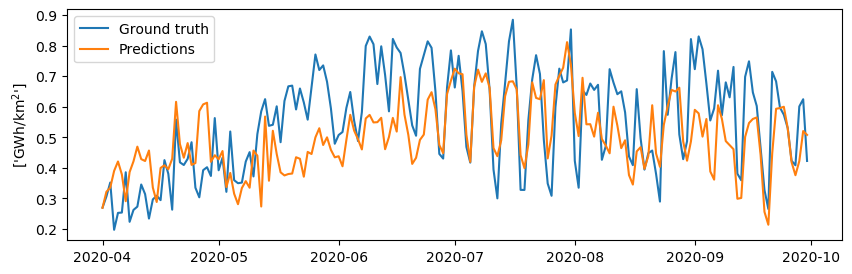

In [15]:
fig, ax = plt.subplots(1,1, figsize=(10,3))

ax.plot(data_validation.time, data_validation.energy, label = 'Ground truth')
ax.plot(data_validation.time, data_validation.predictions, label = 'Predictions')
ax.set_ylabel(['GWh/km$^{2}$'])
ax.legend();